In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

import gc

import logging
import warnings

warnings.filterwarnings('ignore')

In [22]:
!pip install tabulate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"

In [4]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        # --- FIX: Skip Datetime Columns ---
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue
        # -----------------------------------

        # Only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # This is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # Ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # Convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [5]:
print("Loading and reducing memory usage for data files...")
df = pd.read_parquet(f'{DATA_PATH}final_m5_processed.parquet')
df = reduce_mem_usage(df)
print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 2484.67 Mb to 2146.11 Mb (13.6% reduction)

Initial data loading complete.


In [6]:
gc.collect()

60

In [7]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,sell_price,...,wday,month,year,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,11101,2.0,...,1,1,2011,0,0,0,No event,No event,No event,No event
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,11101,2.0,...,2,1,2011,0,0,0,No event,No event,No event,No event
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,11101,2.0,...,3,1,2011,0,0,0,No event,No event,No event,No event
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,11101,2.0,...,4,2,2011,1,1,0,No event,No event,No event,No event
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,11101,2.0,...,5,2,2011,1,0,1,No event,No event,No event,No event


In [8]:
df['has_sale'] = (df['sales'] > 0).astype(int)

In [9]:
df[df['has_sale'] > 0].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,sell_price,...,month,year,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,has_sale
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,11101,2.0,...,1,2011,0,0,0,No event,No event,No event,No event,1
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,11101,2.0,...,2,2011,1,1,0,No event,No event,No event,No event,1
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,11101,2.0,...,2,2011,1,0,1,No event,No event,No event,No event,1
5,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_6,2,11101,2.0,...,2,2011,1,1,1,No event,No event,No event,No event,1
7,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_8,2,11102,2.0,...,2,2011,1,1,1,No event,No event,No event,No event,1


In [10]:
# calendar features
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['week'] = df['date'].dt.isocalendar().week
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [11]:
print(f"Shape: {df.shape}")
df.head()

Shape: (59181090, 29)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,sell_price,...,event_type_1,event_name_2,event_type_2,has_sale,quarter,week,day_of_week,day_of_month,day_of_year,weekend
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,11101,2.0,...,No event,No event,No event,1,1,4,5,29,29,1
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,11101,2.0,...,No event,No event,No event,0,1,4,6,30,30,1
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,11101,2.0,...,No event,No event,No event,0,1,5,0,31,31,0
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,11101,2.0,...,No event,No event,No event,1,1,5,1,1,32,0
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,11101,2.0,...,No event,No event,No event,1,1,5,2,2,33,0


In [12]:
print(df.isnull().sum())

id              0
item_id         0
dept_id         0
cat_id          0
store_id        0
state_id        0
d               0
sales           0
wm_yr_wk        0
sell_price      0
date            0
weekday         0
wday            0
month           0
year            0
snap_CA         0
snap_TX         0
snap_WI         0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
has_sale        0
quarter         0
week            0
day_of_week     0
day_of_month    0
day_of_year     0
weekend         0
dtype: int64


In [13]:
gc.collect()

16

1. price_mean (Average Price per Item/Store) -> calculates the average price for each specific item at each specific store over the entire time period.

Why it's needed: A price of $2.99 is meaningless without context. Is that cheap or expensive? For a loaf of bread, it might be normal. For a single banana, it would be extremely expensive. For a bottle of wine, it would be very cheap. This "normal" price is what the price_mean establishes for each individual item.

2. price_relative_to_mean (Current Price vs. Average Price) ->  calculates the ratio of the current sell_price to the price_mean (e.g., sell_price / price_mean).

Why it's needed: This is a good feature that captures promotions and discounts.

If this value is < 1.0, it means the item is on sale (cheaper than its average). This is a strong signal that might lead to a surge in sales.

If this value is > 1.0, it means the item is priced higher than usual, which might decrease sales.

If this value is ~1.0, it's at its normal price.

A machine learning model can learn this relationship: "When price_relative_to_mean is low, sales are high." This is much more informative than just "the price is $2.49."

3. price_change_lag (Price Change from Previous Day) -> calculates the difference between the price on day D and the price on day D-1.

Why it's needed: This feature captures the "shock" or "event" of a price change.

A large negative value (example: -1.00) indicates the start of a promotion. This is a very strong signal that often causes a big, immediate spike in sales as customers react to the new low price.

A large positive value indicates the end of a promotion. This can cause a sudden drop in sales.

A value of 0 means the price is stable, which is also important information (example: a sale is ongoing, or it's just the normal price).

Summary
While could just give the model the sell_price, it would have to learn the concept of a "normal" price and a "sale" price for all items individually. By engineering these features, we are explicitly giving the model this information, making its job much easier and leading to a more accurate forecast. (I think :)

In [14]:
# mean price per item-store
df['price_mean'] = df.groupby(['item_id', 'store_id'])['sell_price'].transform('mean')

# relative price feature
df['price_relative_to_mean'] = df['sell_price'] / df['price_mean']

# price change from previous day (sorted first for accuracy)
df = df.sort_values(['id', 'date'])
df['price_change_lag'] = df.groupby('id')['sell_price'].diff().fillna(0)

In [15]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,sell_price,...,has_sale,quarter,week,day_of_week,day_of_month,day_of_year,weekend,price_mean,price_relative_to_mean,price_change_lag
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,11101,2.0,...,1,1,4,5,29,29,1,2.168161,0.922441,0.0
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,11101,2.0,...,0,1,4,6,30,30,1,2.168161,0.922441,0.0
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,11101,2.0,...,0,1,5,0,31,31,0,2.168161,0.922441,0.0
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,11101,2.0,...,1,1,5,1,1,32,0,2.168161,0.922441,0.0
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,11101,2.0,...,1,1,5,2,2,33,0,2.168161,0.922441,0.0


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 32 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      category      
 1   item_id                 category      
 2   dept_id                 category      
 3   cat_id                  category      
 4   store_id                category      
 5   state_id                category      
 6   d                       category      
 7   sales                   int16         
 8   wm_yr_wk                int16         
 9   sell_price              float32       
 10  date                    datetime64[ns]
 11  weekday                 category      
 12  wday                    int8          
 13  month                   int32         
 14  year                    int16         
 15  snap_CA                 int8          
 16  snap_TX                 int8          
 17  snap_WI                 int8          
 18  

In [17]:
print(df.shape)

(59181090, 32)


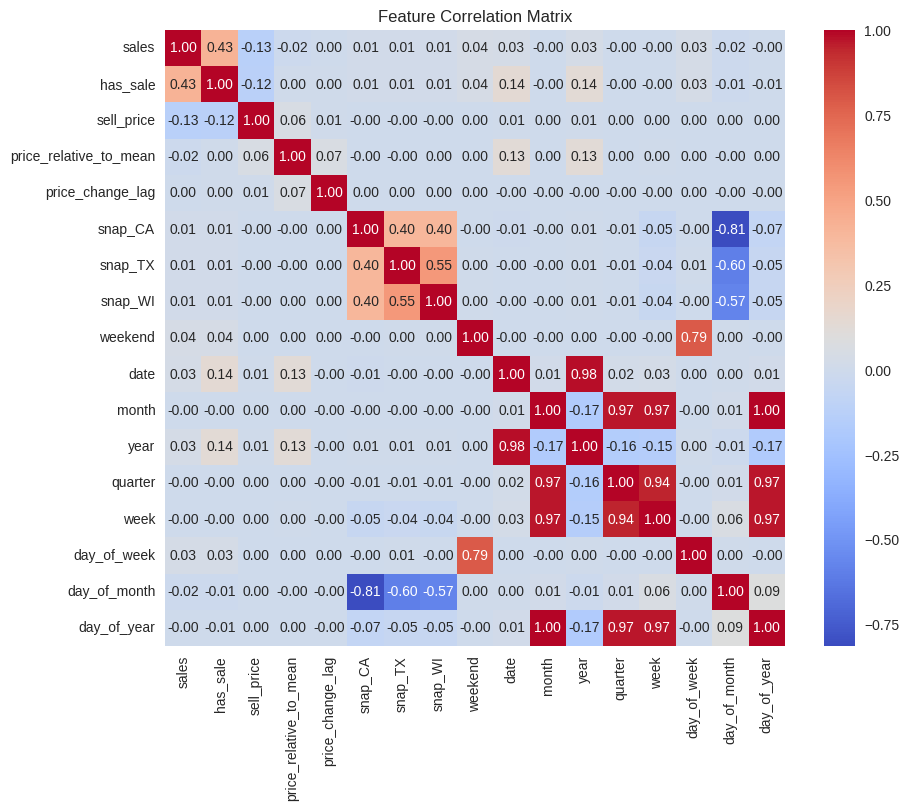

In [18]:
# relevant columns for correlation
corr_cols = [
    'sales',
    'has_sale',
    'sell_price',
    'price_relative_to_mean',
    'price_change_lag',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'weekend',
    'date',
    'month',
    'year',
    'quarter',
    'week',
    'day_of_week',
    'day_of_month',
    'day_of_year',
]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

del corr_matrix, corr_cols

In [19]:
gc.collect()

23201

https://medium.com/@rahulholla1/advanced-feature-engineering-for-time-series-data-5f00e3a8ad29

In [20]:
print(f"Original shape before adding features: {df.shape}")

# sort by id and date to ensure lags are calculated correctly
print("Sorting DataFrame by id and date...")
df.sort_values(by=['id', 'date'], inplace=True)

# gets the sales value from 1 days ago 7, and 28 days ago for the same item
print("Adding lag features (sales_lag_1, sales_lag_7, sales_lag_28)")
df['sales_lag_1'] = df.groupby('id')['sales'].shift(1)
df['sales_lag_7'] = df.groupby('id')['sales'].shift(7)
df['sales_lag_28'] = df.groupby('id')['sales'].shift(28)

# calculates the average sales for the past 28 days for the same item
# .shift(1) is vital to prevent data leakage (using today's sales to predict today)
print("Adding rolling mean feature (sales_rolling_mean_7, sales_rolling_mean_28)")
df['sales_rolling_mean_7'] = df.groupby('id')['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
df['sales_rolling_mean_28'] = df.groupby('id')['sales'].transform(lambda x: x.shift(1).rolling(28).mean())

df['price_lag_7'] = df.groupby('id')['sell_price'].shift(7)
df['price_lag_28'] = df.groupby('id')['sell_price'].shift(28)


print("\nFeature creation complete.")
print(f"New shape after adding features: {df.shape}")

print("\nDataFrame head with new features:")
print("Note: 'NaN' values in new columns for the first rows are expected.")

Original shape before adding features: (59181090, 32)
Sorting DataFrame by id and date...
Adding lag features (sales_lag_1, sales_lag_7, sales_lag_28)
Adding rolling mean feature (sales_rolling_mean_7, sales_rolling_mean_28)

Feature creation complete.
New shape after adding features: (59181090, 39)

DataFrame head with new features:
Note: 'NaN' values in new columns for the first rows are expected.


In [23]:
print(df.isnull().sum().to_markdown())

|                        |      0 |
|:-----------------------|-------:|
| id                     |      0 |
| item_id                |      0 |
| dept_id                |      0 |
| cat_id                 |      0 |
| store_id               |      0 |
| state_id               |      0 |
| d                      |      0 |
| sales                  |      0 |
| wm_yr_wk               |      0 |
| sell_price             |      0 |
| date                   |      0 |
| weekday                |      0 |
| wday                   |      0 |
| month                  |      0 |
| year                   |      0 |
| snap_CA                |      0 |
| snap_TX                |      0 |
| snap_WI                |      0 |
| event_name_1           |      0 |
| event_type_1           |      0 |
| event_name_2           |      0 |
| event_type_2           |      0 |
| has_sale               |      0 |
| quarter                |      0 |
| week                   |      0 |
| day_of_week            |  

In [24]:
gc.collect()

30

We should add more lags and rolling windows if needed:
- sales_lag_7, sales_lag_14, sales_lag_28 (captures weekly patterns) (we already have sales_lag_7 and sales_lag_28)

- sales_rolling_mean_7, sales_rolling_mean_28 (captures recent trends) (we already have sales_rolling_mean_28)

- sales_rolling_std_28 (captures recent volatility. Is the item selling consistently or not?)

Price dynamics:
- price_momentum: sell_price / price_mean (This is similar to price_relative_to_mean but is another way to look at it).

- price_lag_1: The sell_price from 1 day ago. A change in this feature (sell_price != price_lag_1) is a very strong signal

Also, we should later need the seasonal interaction features:
- day_of_week_x_month: Combine these two to see if, for example, Saturdays in December are different from Saturdays in July.

- item_x_day_of_week_sales: The average sales for a specific item_id on a specific day_of_week. (e.g., "Item A always sells well on Sundays"). This is a very powerful but computationally heavy feature to create.

In [25]:
print(df.columns.tolist())

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'wm_yr_wk', 'sell_price', 'date', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'has_sale', 'quarter', 'week', 'day_of_week', 'day_of_month', 'day_of_year', 'weekend', 'price_mean', 'price_relative_to_mean', 'price_change_lag', 'sales_lag_1', 'sales_lag_7', 'sales_lag_28', 'sales_rolling_mean_7', 'sales_rolling_mean_28', 'price_lag_7', 'price_lag_28']


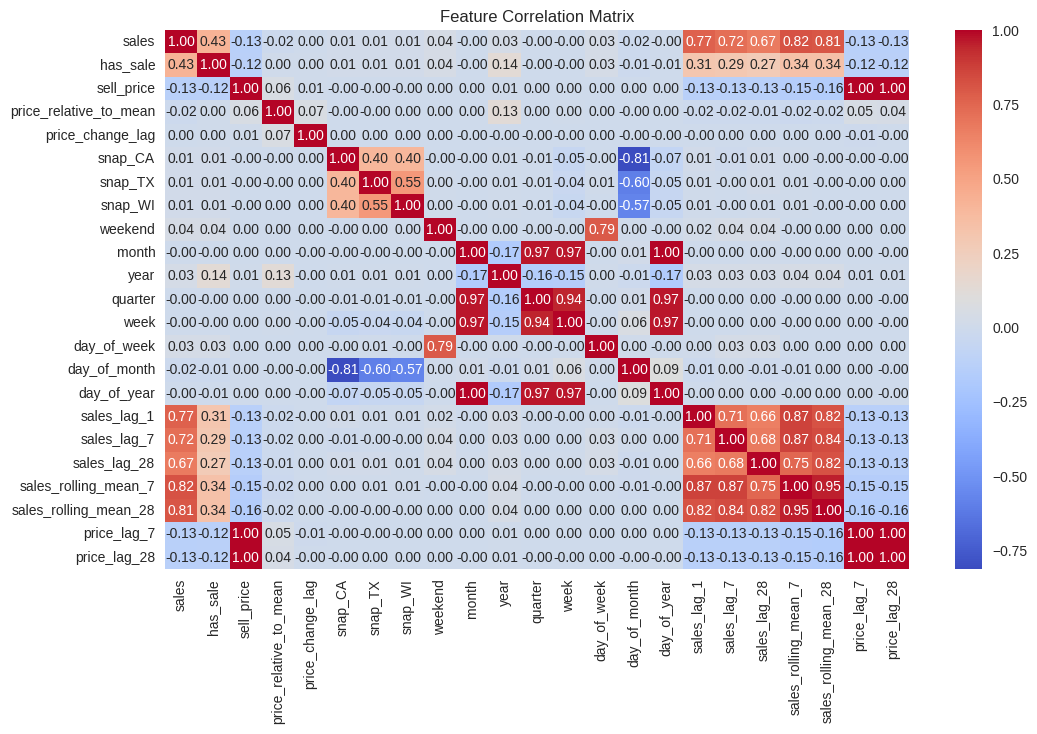

In [26]:
# relevant columns for correlation
corr_cols = [
    'sales',
    'has_sale',
    'sell_price',
    'price_relative_to_mean',
    'price_change_lag',

    'snap_CA',
    'snap_TX',
    'snap_WI',
    'weekend',
    'month',
    'year',
    'quarter',
    'week',
    'day_of_week',
    'day_of_month',
    'day_of_year',

    'sales_lag_1',
    'sales_lag_7',
    'sales_lag_28',
    'sales_rolling_mean_7',
    'sales_rolling_mean_28',
    'price_lag_7',
    'price_lag_28'
]


corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

del corr_matrix, corr_cols

In [27]:
gc.collect()

37642

In [28]:
df.isnull().sum()

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
sales,0
wm_yr_wk,0
sell_price,0


## Handling Seasonality (beyond just month or week)

https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

Current features: month, day_of_week, and day_of_year are good, but we can make them more powerful. Models (especially linear ones, but also trees) struggle to understand that December (12) is "close" to January (1). So, we can fix this by encoding these features cyclically.

In [29]:
# month
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# day of month
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month']/31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month']/31)

# day of week
df['day_of_week_sin'] = np.sin(2 * np.pi * df['wday']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['wday']/7)

print("\nHandling Seasonality Features Cyclically.")


Handling Seasonality Features Cyclically.


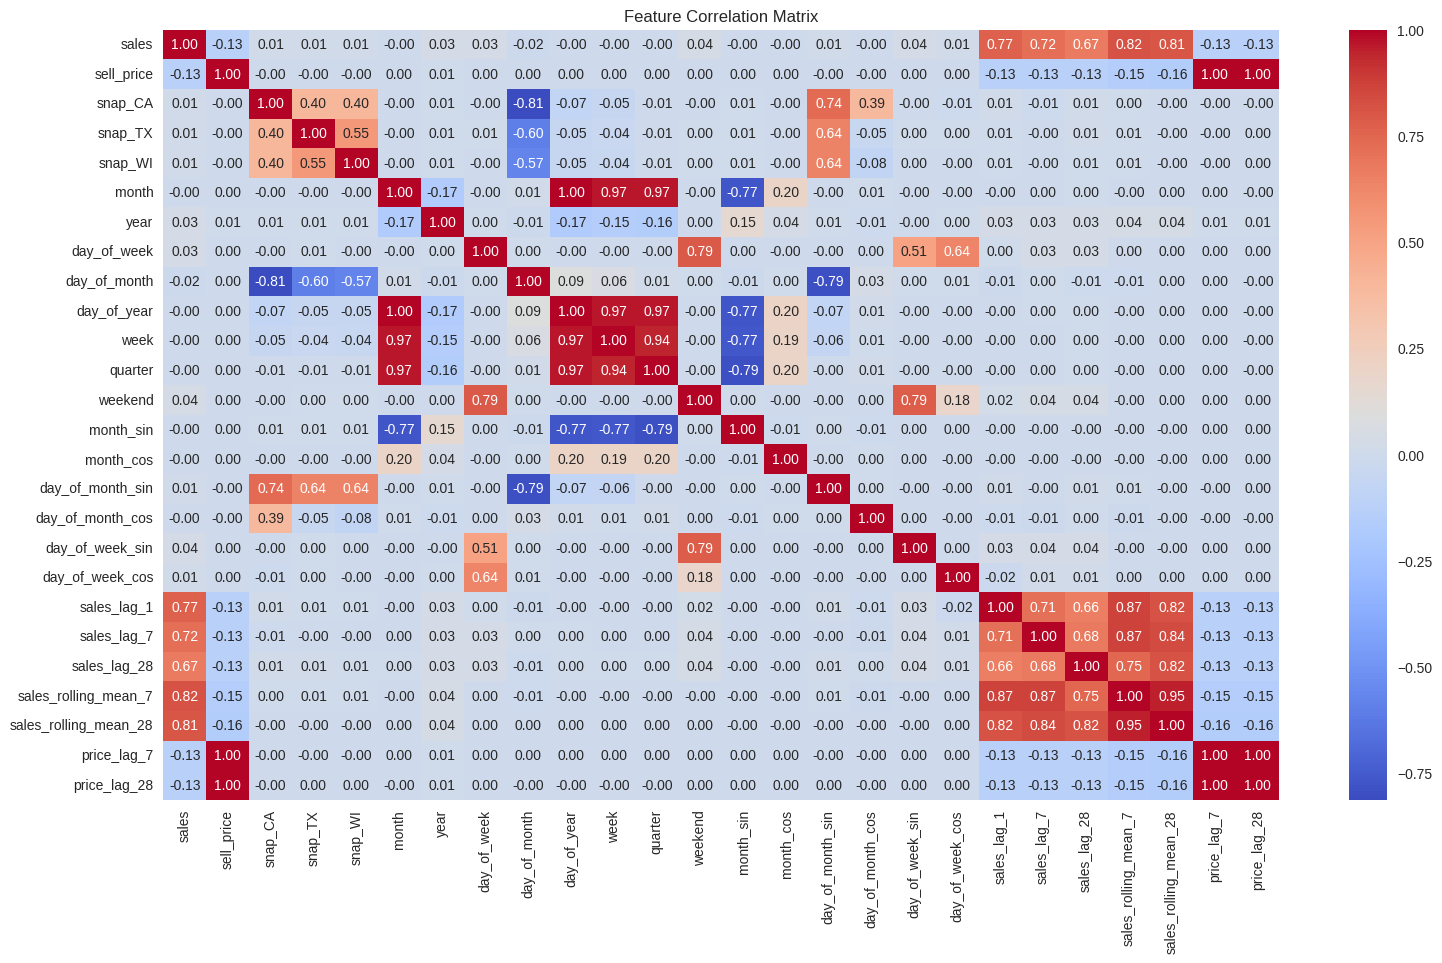

In [30]:
# relevant columns for correlation
corr_cols = [
    'sales',
    'sell_price',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'month',
    'year',
    'day_of_week',
    'day_of_month',
    'day_of_year',
    'week',
    'quarter',
    'weekend',
    'month_sin', 'month_cos',
    'day_of_month_sin', 'day_of_month_cos',
    'day_of_week_sin', 'day_of_week_cos',

    'sales_lag_1',
    'sales_lag_7',
    'sales_lag_28',
    'sales_rolling_mean_7',
    'sales_rolling_mean_28',
    'price_lag_7',
    'price_lag_28'
]


corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

gc.collect()

del corr_matrix, corr_cols

In [31]:
print(f"Shape before dropping: {df.shape}")

columns_to_drop = [
    # 'weekend' # we may dropping this as it's captured by day_of_week sin/cos (but we may do in the modeling step)
]

# check which columns exist in the DataFrame before trying to drop them
# this prevents a KeyError if a column has already been dropped
columns_that_exist = [col for col in columns_to_drop if col in df.columns]

df = df.drop(columns=columns_that_exist)

print(f"Shape after dropping: {df.shape}")

Shape before dropping: (59181090, 45)
Shape after dropping: (59181090, 45)


## If nedded
Event & Holiday Features (More specific than just event_name)

Right now, we have event_name (e.g., "Christmas"). This is good, but we can add features that capture the "run-up" to an event, which is often more important than the day itself.

Days Until/Since Next Holiday: How many days until Christmas? How many days since Christmas? This captures pre-holiday rushes and post-holiday lulls.

Holiday Phase: A categorical feature like "Pre-Christmas," "Christmas-Week," "Post-Christmas."

--
Is_Event_Day: A simple binary (1 or 0) flag. Current event_name_1 is "No event" for most days, which is inefficient. A 1/0 feature is cleaner.

In [32]:
df.isnull().sum()

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
sales,0
wm_yr_wk,0
sell_price,0


## Processing for NaN again after adding lag and rolling features
1. Drop those rows that contain nan values, because they are not missing data, they are un-learnable rows. Keeping them would actually hurt the model's performance
So, dropping those rows is statistically safe decision.

Some more views from those column's meaning:
- sales_lag_28: "What were the sales 28 days ago?"
- sales_rolling_mean_28: "What were the average sales over the last 28 days?"

Now, consider Day 15 for a new item.

What were the sales 28 days ago? We don't know. The data doesn't exist. The value is NaN.

What were the average sales over the last 28 days? We can't calculate it. The value is NaN.

For these NaN rows, the model's most powerful new features are completely blind. The row is important for being a sales record, but it's useless for training a model that depends on historical trends.

Simple Analogy: Imagine trying to predict a student's test score trend on their very first day of school. You can't. You have no trend data. These NaN rows are the "first days of school" for each item. You have to wait until Day 29 to have a full 28-day history to analyze.

2. Why Keeping or Filling Them Is Worse (The "Lying" Problem)
You might think, "What if we just fill the NaNs with 0?" This is actually the worst thing you could do.

Filling with 0 is a lie. By filling with 0, you are explicitly telling the model, "I know for a fact that the sales for this item were 0 for the last 28 days."

The Model Learns the Lie. The model will learn this (false) pattern: "Ah, for new items, sales are always 0 for 28 days, and then they suddenly start." This is a deeply biased pattern that will lead to terrible predictions.

Dropping the row is telling the model, "Don't learn from this row; the data is incomplete." Filling the row is actively "poisoning" your model with false data.

In [33]:
print(f"Shape before dropping NaNs: {df.shape}")

df.dropna(
    subset=[
        'sales_lag_1',
        'sales_lag_7',
        'sales_lag_28',
        'sales_rolling_mean_7',
        'sales_rolling_mean_28',
        'price_lag_7',
        'price_lag_28'
    ],
    inplace=True
)

print(f"Shape after dropping NaNs: {df.shape}")

Shape before dropping NaNs: (59181090, 45)
Shape after dropping NaNs: (58327370, 45)


In [34]:
# verify null after dropped
df.isnull().sum()

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
sales,0
wm_yr_wk,0
sell_price,0


## Removing features before modeling

Features to remove before modeling
- weekday: we already have day_of_week as number and wday (seems similar). Having "Saturday" from weekday and 5 from day_of_week is redundant. The model needs numeric representation, so we keep day_of_week.
- d: just the id for the day. The date column and other date-based features like day_of_year, year capture all the time information.
- wm_yr_wk: We already have year and day_of_year and month.
- id: This (FOODS_1_001_CA_1_evaluation) is just a unique identifier for the row (a combination of item_id and store_id). The model should learn from item_id and store_id as separate features.

In [35]:
# sort by id before drop (id contain the item_id + store_id)
df.sort_values(by=['item_id', 'date'], inplace=True)

In [36]:
print(f"Shape before dropping NaNs: {df.shape}")

df.drop(columns=['weekday', 'wm_yr_wk', 'id'], inplace=True)

print(f"Shape after dropping NaNs: {df.shape}")

Shape before dropping NaNs: (58327370, 45)
Shape after dropping NaNs: (58327370, 42)


After EDA, we can now drop date column as we already extracted the date features to other features like month, year, day_of_week

In [37]:
print(f"Shape before dropping NaNs: {df.shape}")

# df.drop(columns=['date'], inplace=True)

print(f"Shape after dropping NaNs: {df.shape}")

Shape before dropping NaNs: (58327370, 42)
Shape after dropping NaNs: (58327370, 42)


In [38]:
print(df.columns)

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales',
       'sell_price', 'date', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'has_sale', 'quarter', 'week', 'day_of_week',
       'day_of_month', 'day_of_year', 'weekend', 'price_mean',
       'price_relative_to_mean', 'price_change_lag', 'sales_lag_1',
       'sales_lag_7', 'sales_lag_28', 'sales_rolling_mean_7',
       'sales_rolling_mean_28', 'price_lag_7', 'price_lag_28', 'month_sin',
       'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'day_of_week_sin',
       'day_of_week_cos'],
      dtype='object')


In [39]:
print(df.head().to_markdown())

|      | item_id     | dept_id   | cat_id   | store_id   | state_id   | d    |   sales |   sell_price | date                |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   has_sale |   quarter |   week |   day_of_week |   day_of_month |   day_of_year |   weekend |   price_mean |   price_relative_to_mean |   price_change_lag |   sales_lag_1 |   sales_lag_7 |   sales_lag_28 |   sales_rolling_mean_7 |   sales_rolling_mean_28 |   price_lag_7 |   price_lag_28 |   month_sin |   month_cos |   day_of_month_sin |   day_of_month_cos |   day_of_week_sin |   day_of_week_cos |
|-----:|:------------|:----------|:---------|:-----------|:-----------|:-----|--------:|-------------:|:--------------------|-------:|--------:|-------:|----------:|----------:|----------:|:---------------|:---------------|:---------------|:---------------|-----------:|----------:|-------:|--------------:|---------------:|--------------:|-

In [40]:
df.to_parquet(DATA_PATH + "final_m5_model_data.parquet", index=False)